# German Traffic Sign Classification

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os
import plotly
import plotly.graph_objs as go
import time
import itertools
import seaborn as sns
import warnings
import tqdm
import math
from mpl_toolkits.mplot3d import Axes3D
import tensorflow_addons as tfa
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
plotly.offline.init_notebook_mode(True)

## Exploratory Data Analysis & Data Wrangling

#### Here we will be creating the functions for plotting of graph by per column distribution,Correlation Matrix and Scatter Plot

In [2]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


In [3]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


In [4]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


Now you're ready to read in the data and use the plotting functions to visualize the data.

### Let's check 1st file: Meta.csv

In [5]:
nRowsRead = 1000 # specify 'None' if want to read whole file
df1 = pd.read_csv('Meta.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'Meta.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 43 rows and 5 columns


Let's take a quick look at what the data looks like:

In [6]:
df1.head(5)

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22


Distribution graphs (histogram/bar graph) of sampled columns:

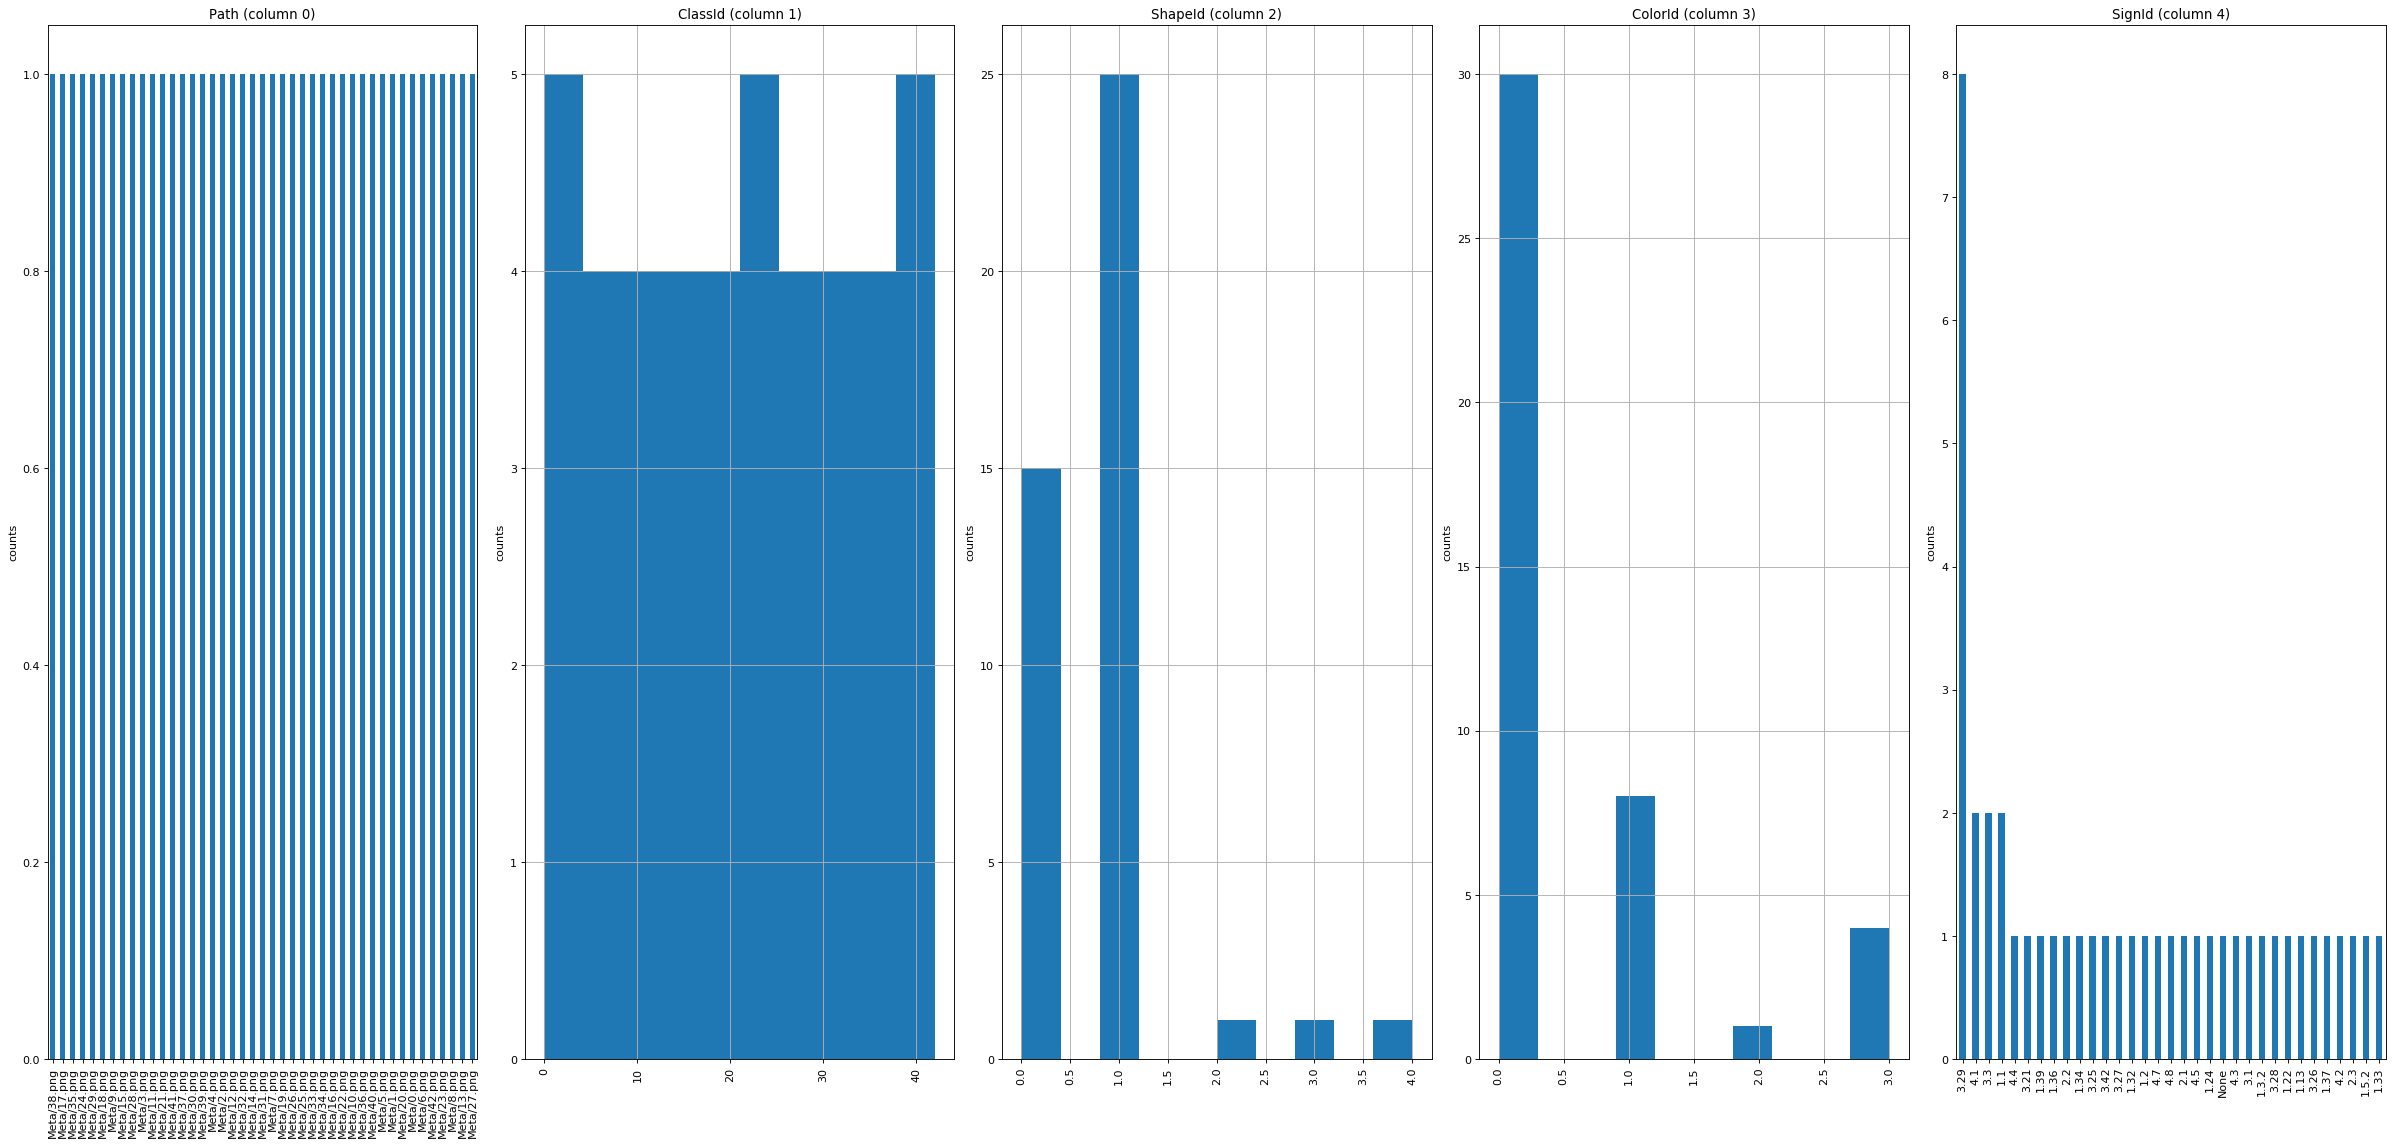

In [7]:
plotPerColumnDistribution(df1, 10, 5)

Correlation matrix:

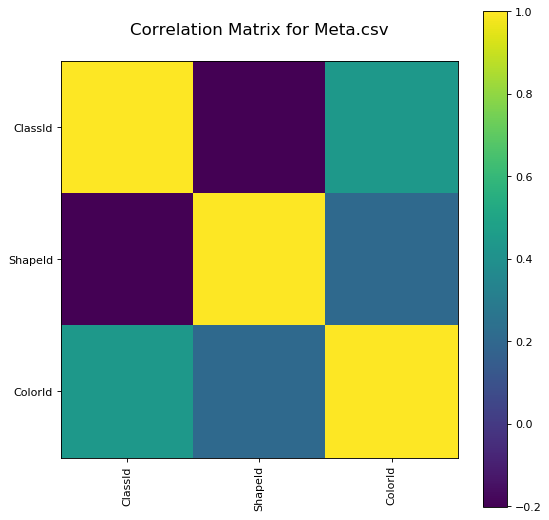

In [8]:
plotCorrelationMatrix(df1, 8)

Scatter and density plots:

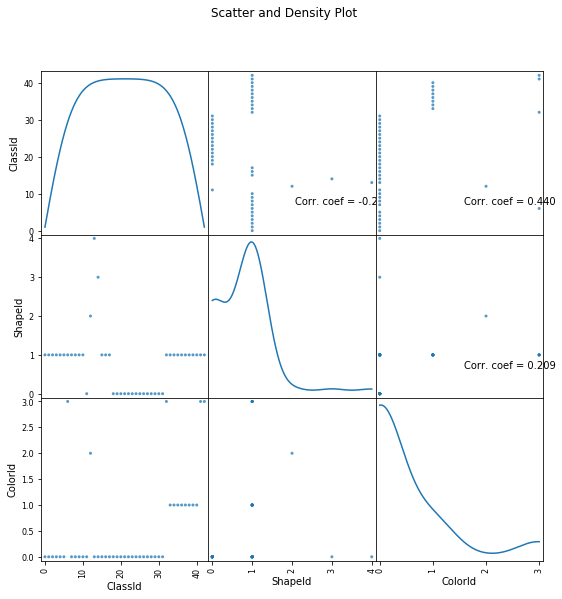

In [9]:
plotScatterMatrix(df1, 9, 10)

### Let's check 2nd file: Test.csv

In [10]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# Test.csv has 12630 rows in reality, but we are only loading/previewing the first 1000 rows
df2 = pd.read_csv('Test.csv', delimiter=',', nrows = nRowsRead)
df2.dataframeName = 'Test.csv'
nRow, nCol = df2.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 8 columns


Let's take a quick look at what the data looks like:

In [11]:
df2.head(5)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


Distribution graphs (histogram/bar graph) of sampled columns:

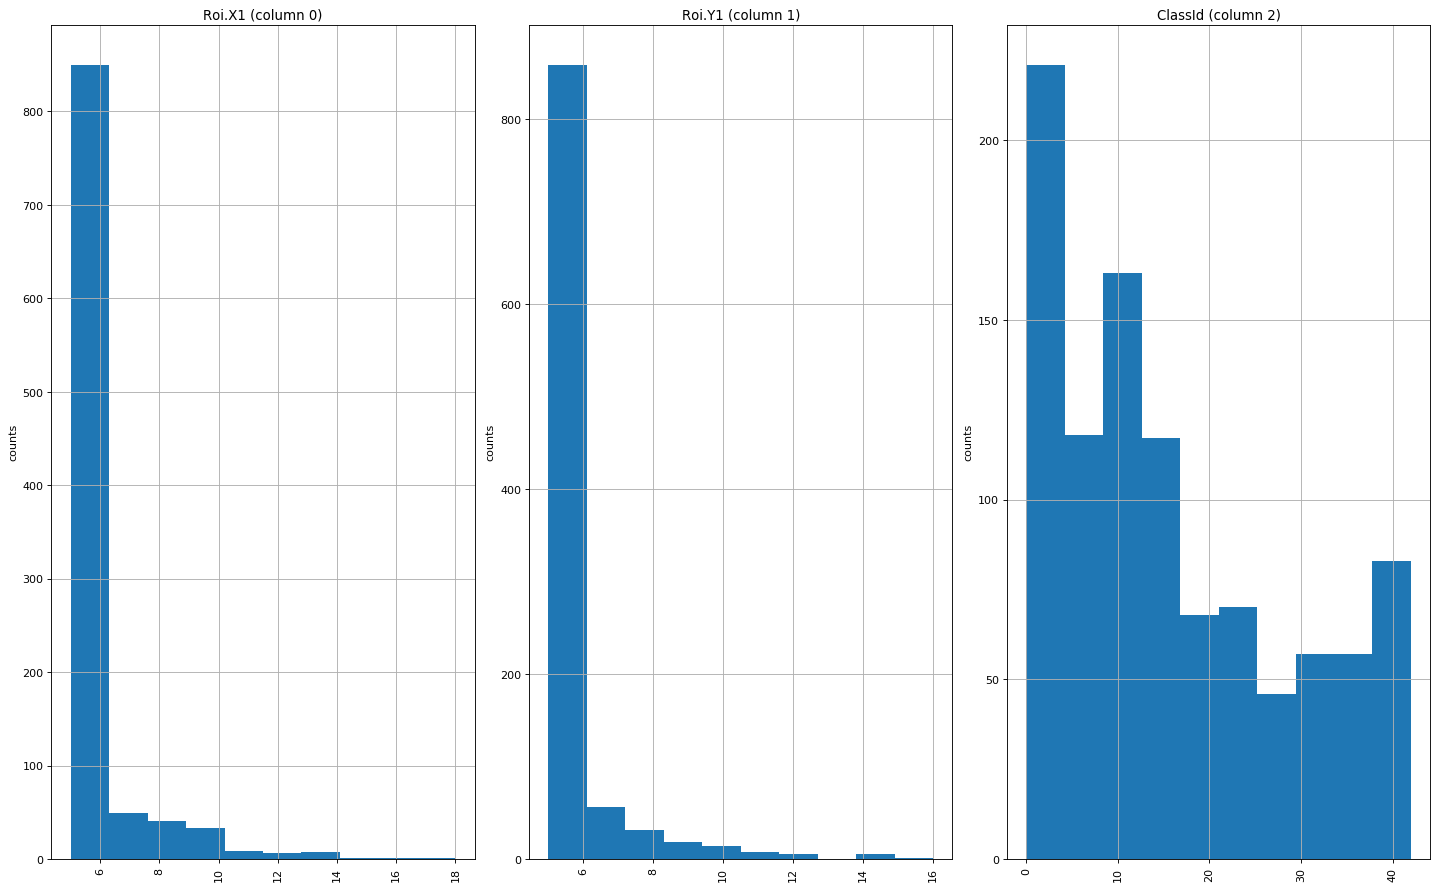

In [12]:
plotPerColumnDistribution(df2, 10, 5)

Correlation matrix:

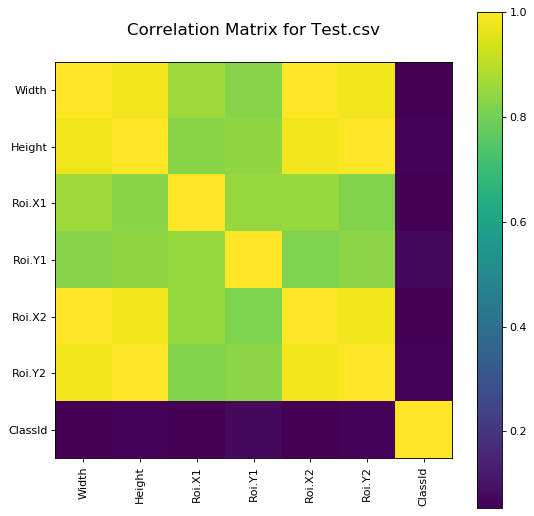

In [13]:
plotCorrelationMatrix(df2, 8)

Scatter and density plots:

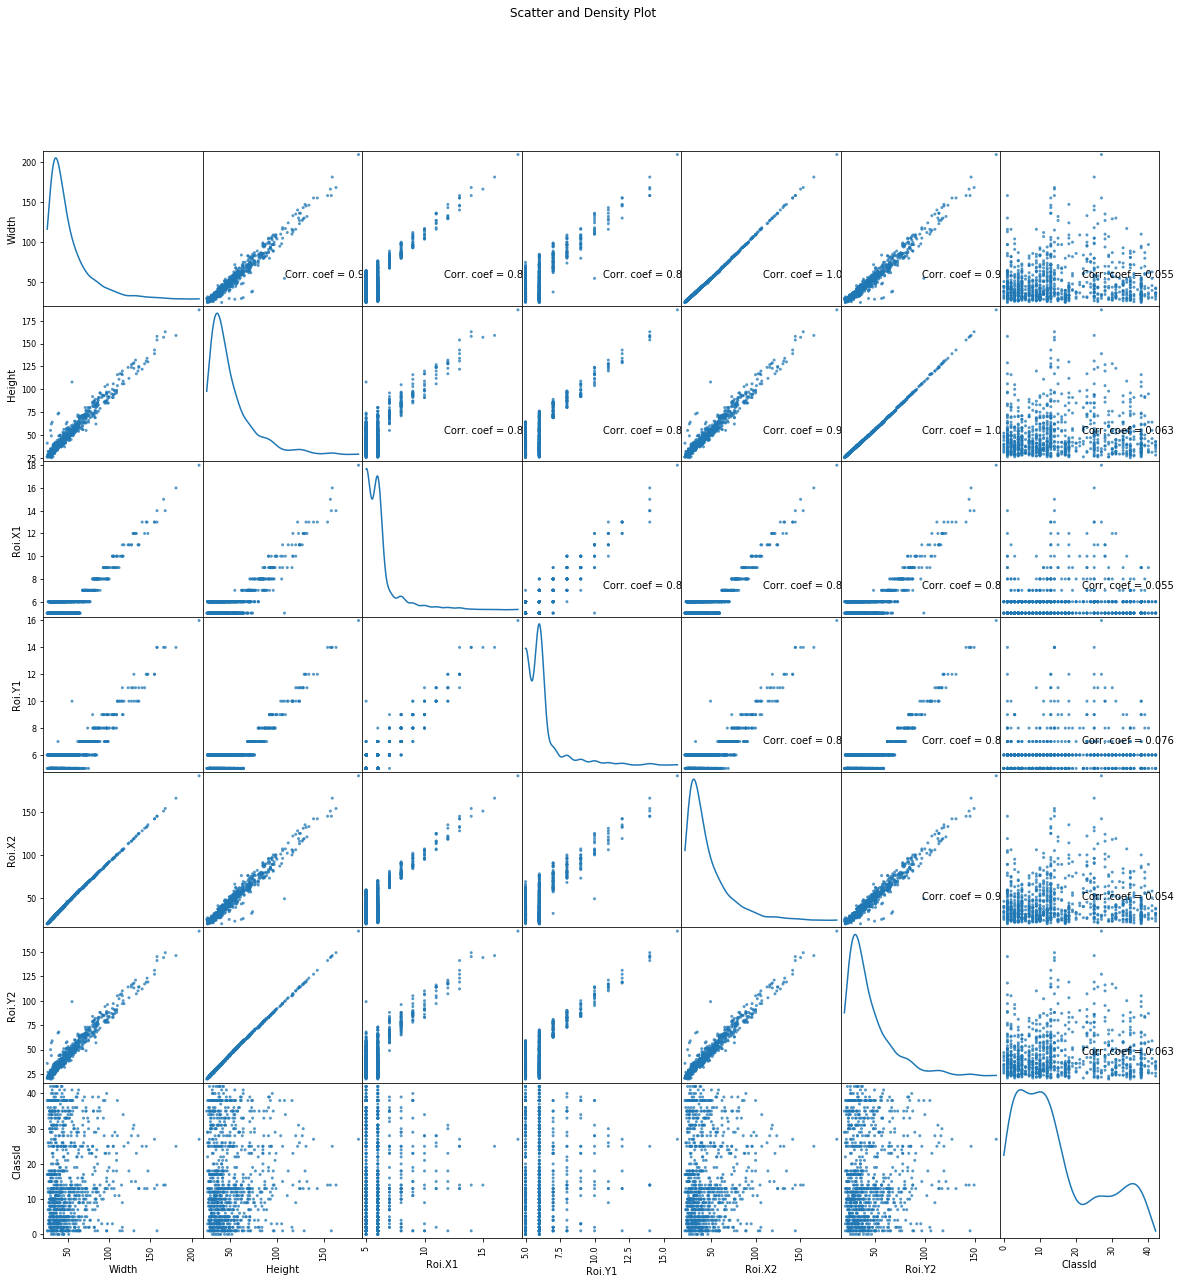

In [14]:
plotScatterMatrix(df2, 20, 10)

### Let's check 3rd file: Train.csv

In [15]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# Train.csv has 39209 rows in reality, but we are only loading/previewing the first 1000 rows
df3 = pd.read_csv('Train.csv', delimiter=',', nrows = nRowsRead)
df3.dataframeName = 'Train.csv'
nRow, nCol = df3.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 8 columns


Let's take a quick look at what the data looks like:

In [16]:
df3.head(5)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


Distribution graphs (histogram/bar graph) of sampled columns:

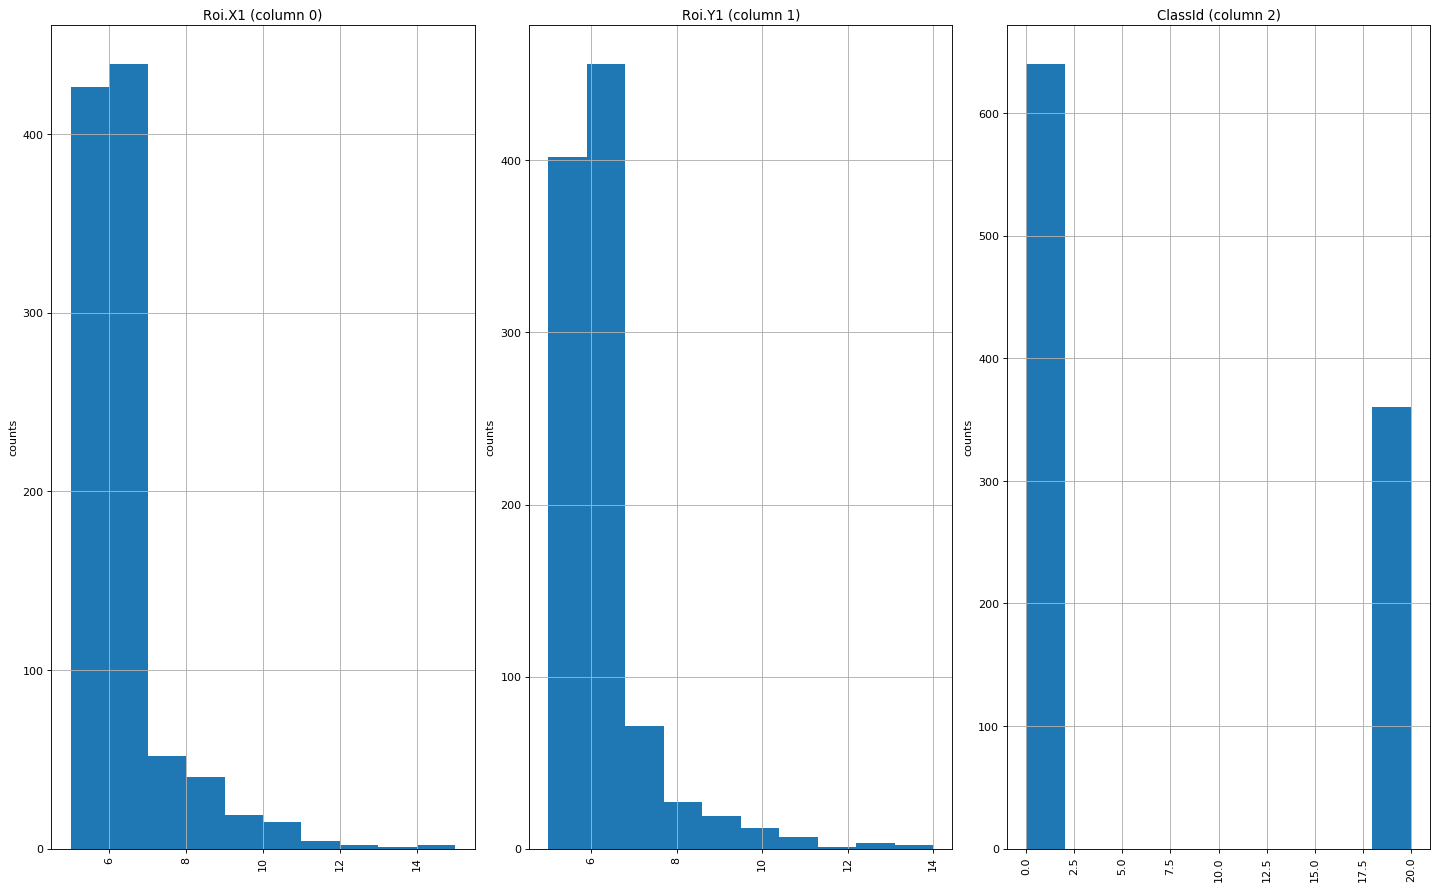

In [17]:
plotPerColumnDistribution(df3, 10, 5)

Correlation matrix:

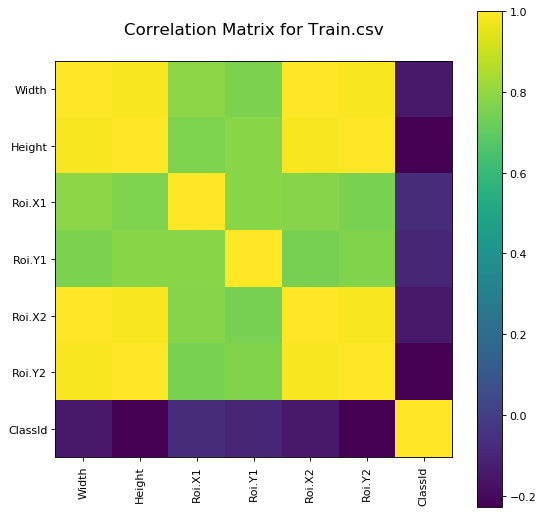

In [18]:
plotCorrelationMatrix(df3, 8)

Scatter and density plots:

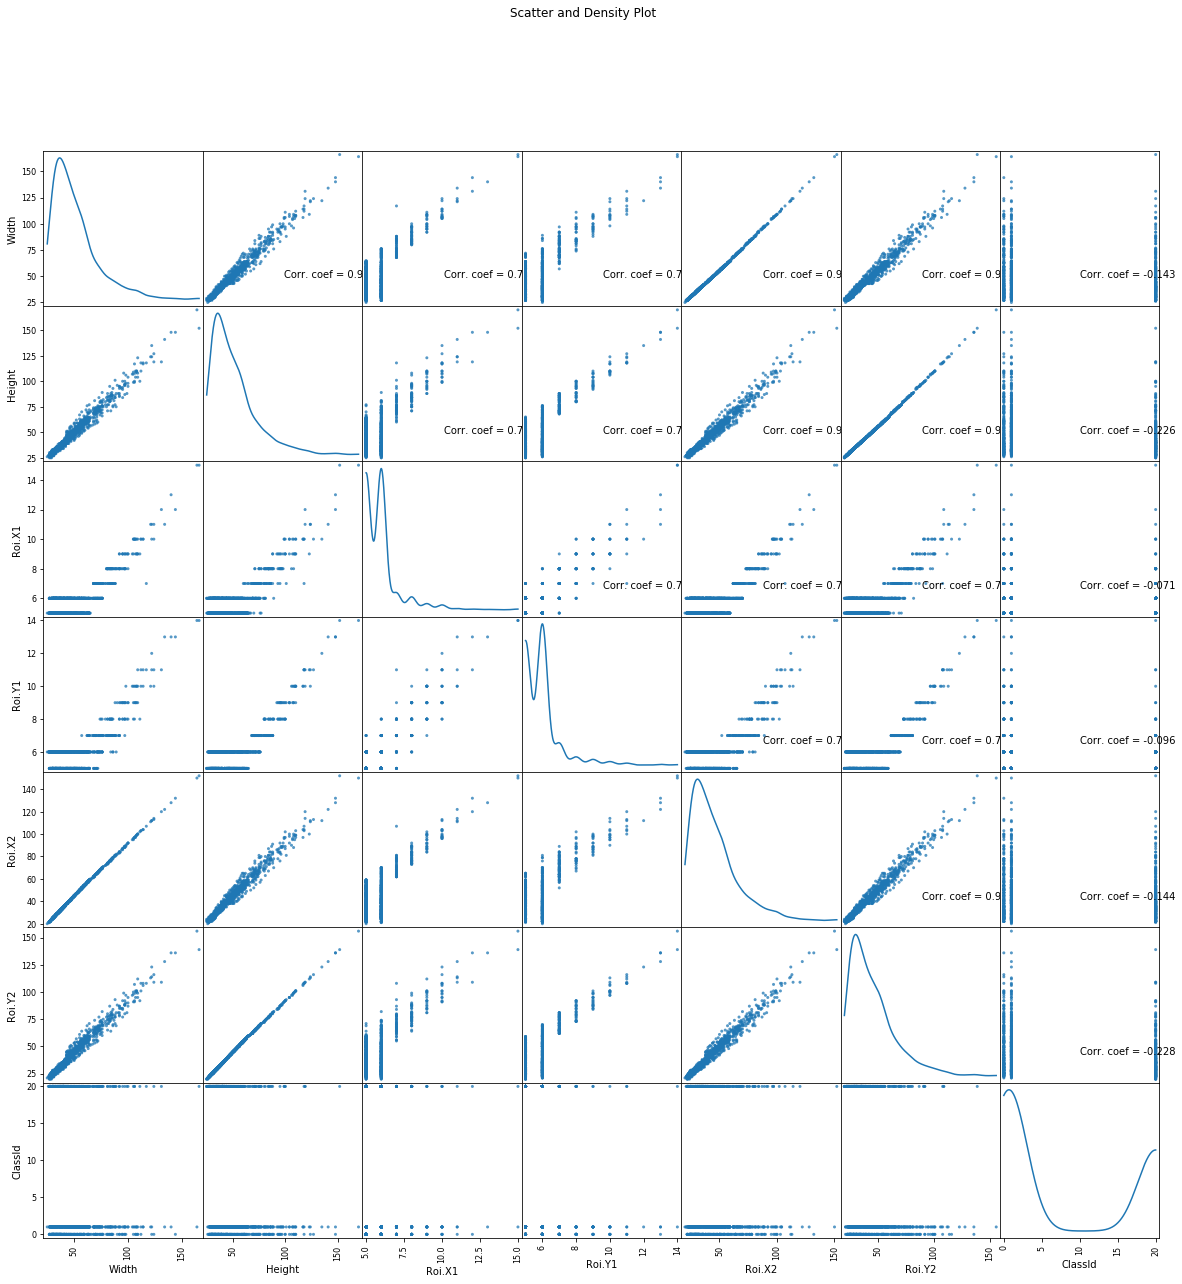

In [19]:
plotScatterMatrix(df3, 20, 10)

In [20]:
data = []
labels = []
classes = 43
cur_path = os.getcwd()


#Retrieving the images and their labels 
for i in range(classes):
    path = os.path.join(cur_path,'train',str(i))
    images = os.listdir(path)

    for a in images:
        try:
            image = Image.open(path + '\\'+ a)
            image = image.resize((30,30))
            image = np.array(image)
            #sim = Image.fromarray(image)
            data.append(image)
            labels.append(i)
        except:
            print("Error loading image")

#Converting lists into numpy arrays
data = np.array(data)
labels = np.array(labels)
print(data.shape, labels.shape)


#Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#Converting the labels into one hot encoding
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)




(39209, 30, 30, 3) (39209,)
(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


In [23]:
X_train.shape

(31367, 30, 30, 3)

### Creating The Model

In [24]:
#Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

#Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 15
pg = tfa.callbacks.TQDMProgressBar()
model_callbacks = [pg, ]
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, verbose=0, validation_data=(X_test, y_test),callbacks = model_callbacks)


Epoch 1/15



Epoch 2/15



Epoch 3/15



Epoch 4/15



Epoch 5/15



Epoch 6/15



Epoch 7/15



Epoch 8/15



Epoch 9/15



Epoch 10/15



Epoch 11/15



Epoch 12/15



Epoch 13/15



Epoch 14/15



Epoch 15/15


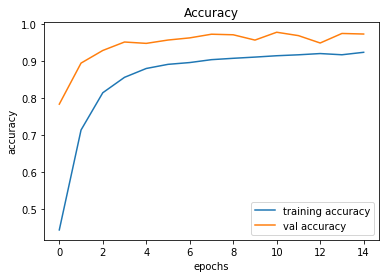

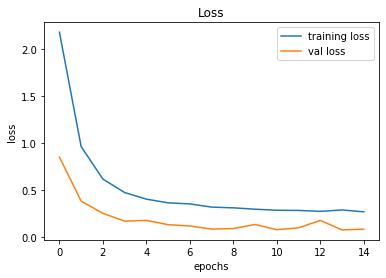

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
0.9434679334916865


In [26]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig("Accuracy",bbox_inches = 'tight')
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.savefig("Loss",bbox_inches = 'tight')
plt.show()

#testing accuracy on test dataset
from sklearn.metrics import accuracy_score

test_data = pd.read_csv('Test.csv')

labels = test_data["ClassId"].values
imgs = test_data["Path"].values

data=[]

for img in imgs:
    image = Image.open(img)
    image = image.resize((30,30))
    data.append(np.array(image))

X_test=np.array(data)

y_pred = model.predict_classes(X_test)

#Accuracy with the test data
from sklearn.metrics import accuracy_score
print(accuracy_score(labels, y_pred))